In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy import stats
import cv2 

In [2]:
#乱数の固定
np.random.seed(seed=1)

In [3]:
#定数
##画像のサイズ
height=200
width=200
##状態数
S1=2
S2=2
##カラー画像
D=3

In [4]:
# \mu \Lambdaのハイパーパラメーター
M = np.zeros((S1,S2,D))
M[0,0,:]=np.array([0.0,0.0,250.0])
M[0,1,:]=np.array([0.0,250.0,0.0])
M[1,0,:]=np.array([250.0,0.0,0.0])
M[1,1,:]=np.array([0.0,0.0,0.0])
BETA = np.ones((S1,S2))/10000
W= np.zeros((S1,S2,D,D))
for s1 in range(S1):
    for s2 in range(S2):
        W[s1,s2,:,:]=np.identity(D)
NU = np.ones((S1,S2))*3
#\pi のハイパーパラメーター
ETA1 = np.array([0.3,0.7])
ETA2 = np.array([0.7,0.3])
# Aのハイパーパラメーター
EPSILON1 = np.array([[1,1],[1,1]])
EPSILON2 = np.array([[1,1],[1,1]])

In [5]:
#画像生成(拡張分離型格子隠れマルコフモデル)
class product:
    def __init__(self):
        #パラメーター
        ##出力
        self.mu = np.zeros((S1,S2,D))
        self.lam = np.zeros((S1,S2,D,D))
        ##初期状態確率
        self.pi1 = np.zeros((S1))
        self.pi2 = np.zeros((S2))
        ##遷移確率
        self.a1 = np.zeros((S1,S1))
        self.a2 = np.zeros((S2,S2))
        ##状態
        self.s1 = np.zeros((height,width),int)
        self.s2 = np.zeros((height,width),int)
        
    #\theta=\{\mu \lamda \pi \a \}
    def theta(self):
        self.pi1=np.random.dirichlet(ETA1)
        self.pi2=np.random.dirichlet(ETA2)
        
        for s1 in range(S1):
            self.a1[s1]=np.random.dirichlet(EPSILON1[s1])
        for s2 in range(S2):
            self.a2[s2]=np.random.dirichlet(EPSILON2[s2])
        
        for s1 in range(S1):
            for s2 in range(S2):
                self.lam[s1,s2,:,:]=stats.wishart(df=NU[s1,s2],scale=W[s1,s2,:,:]).rvs(1)
                self.mu[s1,s2,:]=np.random.multivariate_normal(M[s1,s2,:],np.linalg.inv(BETA[s1,s2]*self.lam[s1,s2,:,:]))

    #S^(1)
    def S1(self):
        for i in range(0,height):
            for j in range(0,width):
                if(j==0):
                    self.s1[i,j]=np.random.choice(S1,p=self.pi1)
                else:
                    self.s1[i,j]=np.random.choice(S1,p=self.a1[self.s1[i,j-1]])

    #S^(2)
    def S2(self):
        for j in range(0,width):
            for i in range(0,height):
                if(i==0):
                    self.s2[i,j]=np.random.choice(S2,p=self.pi2)
                else:
                    self.s2[i,j]=np.random.choice(S2,p=self.a2[self.s2[i-1,j]])
    #画像生成
    def image_produce(self):
        self.theta()
        self.S1()
        self.S2()
        self.image=np.zeros((height,width,D))
        for i in range(0,height):
            for j in range(0,width):
                self.image[i,j,:]=np.random.multivariate_normal(self.mu[self.s1[i,j],self.s2[i,j],:],np.linalg.inv(self.lam[self.s1[i,j],self.s2[i,j],:,:]))
        
        self.image[self.image>255.0]=255.0
        self.image[self.image<0.0]=0.0
        self.image=(self.image).astype(np.uint8)
         
        plt.imshow(self.image,vmin=0,vmax=255)
        plt.show()
        #74

In [6]:
model=product()

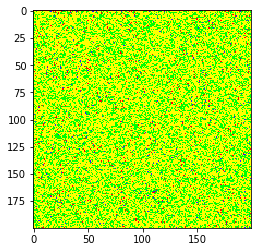

In [7]:
model.image_produce()

In [35]:
cv2.imwrite("gene2.png",model.image)     

True

In [36]:
im=np.array(Image.open('gene2.png'))
im=im[:,:,::-1]
pil_img = Image.fromarray(im)
pil_img.save('gene2.png')